### Programming for Biomedical Informatics
#### Week 4 - Mining & Analysing the Biomedical Literature

Using some of the skills we've developed working with eUtils we're now going to do some literature mining and analysis to gather some evidence about a rare genetic disease called Rett Syndrome.

In [3]:
%pip install matplotlib_venn

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib_venn: filename=matplotlib_venn-1.1.1-py3-none-any.whl size=45335 sha256=5736b718a7fd8019998142bbb236e231f4e75f2cfe3c682dfdbdbcd6cbf17098
  Stored in directory: c:\users\const\appdata\local\pip\cache\wheels\8a\29\52\4d90d9556445079f88255b87a75d951357eff52d0795b88f4f
Successfully built matplotlib_venn
Note: you may need to restart the kernel to use updated packages.


In [5]:
'''In this script we are going to directly query eUtils using the requests library. This is because it allows us to easily specify the parameters and use the history feature of eUtils to make large queries efficiently.
In the code below you should begin to see a pattern for how we approach the mapping process.'''

# Preliminaries
import urllib.request
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# we will use this to allow us to search the XML content retutned by the eUtils API
import xml.etree.ElementTree as ET

# load my API key from the file
with open('../api_keys/ncbi.txt', 'r') as file:
    api_key = file.read().strip()

with open('../api_keys/ncbi_email.txt', 'r') as file:
    email = file.read().strip()

In [ ]:
# Step 1 - Creating a specific search to find articles relating to Rett Syndrome

'''A good place to start is to search MeSH to see if a specific term for "Rett Syndrom" exists. If it does we can
use this to perform a PubMed search. Experimentally it makes sense to try a few different phrasings and methods
to search for Rett Syndrome to see how much the results vary.

https://meshb.nlm.nih.gov

It would make sense to do some analysis of this; for example we could retrieve the PubMedIds for the different searches
and comapre them to see how much overlap there is. This would give us confidence in our search strategy.'''

In [7]:
# Search PubMed for articles relating to Rett Syndrome using eUtils API
# Define the parameters for the eSearch request

'''as we're going to make a few different searches we can define a function to do this for us'''

def pubmed_search_count(query, api_key, email):

    # define the parameters for the eSearch request
    esearch_params = {
        'db': 'pubmed',
        'term': query,
        'api_key': api_key,
        'email': email
    }

    # encode the parameters so they can be passed to the API
    encoded_data = urllib.parse.urlencode(esearch_params).encode('utf-8')

    # the base request url for eSearch
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"

    # make the request
    request = urllib.request.Request(url, data=encoded_data)
    response = urllib.request.urlopen(request)

    # read into an XML object
    esaerch_data_XML = ET.fromstring(response.read())

    # extract the couunt of the number of articles found
    count = int(esaerch_data_XML.find('Count').text)

    print(f"Found {count} articles")

In [8]:
# try a search with the MeSH term for Rett Syndrome
pubmed_search_count('"Rett Syndrome" [MH]', api_key=api_key, email=email)
# Note: can get discrepencies between web searches & API searches (e.g. dates: publication date vs date added -> web search will thake liberties)

Found 3073 articles


In [9]:
# now lets try an allfields search for Rett Syndrome
pubmed_search_count('Rett Syndrome', api_key=api_key, email=email)
# Want a search that's broad enough, but minimises the "false positives"! Need proper heuristics.

Found 4710 articles


In [10]:
# lets modify the function above to return the list of PubMedIds, not just the count

def pubmed_search_ids(query, api_key, email):
    
        # define the parameters for the eSearch request
        esearch_params = {
            'db': 'pubmed',
            'term': query,
            'api_key': api_key,
            'email': email
        }

        # encode the parameters so they can be passed to the API
        encoded_data = urllib.parse.urlencode(esearch_params).encode('utf-8')

        # the base request url for eSearch
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"

        # make the request
        request = urllib.request.Request(url, data=encoded_data)
        response = urllib.request.urlopen(request)

        # read into an XML object
        esaerch_data_XML = ET.fromstring(response.read())

        # extract all the IDs in the response
        ids = [id.text for id in esaerch_data_XML.findall('IdList/Id')]
        # Note: can print out an example of XML data for a few entries in response as template for search query structure

        return ids


# try a search with the MeSH term for Rett Syndrome
ids = pubmed_search_ids('"Rett Syndrome"[MH]', api_key, email)

# print the number of ids found
print(len(ids))

20


In [ ]:
'''so you can see the search BY DEFAULT will return 20 ids (you can modify retmax, but you'd need to adjust it based on the count return
which in effect would call the search twice. This is why we use the HISTORY FEATURE OF EUTILS to make large queries efficiently)'''

In [12]:
# lets modify the function above to return the list of PubMedIds

def pubmed_search_ids(query, api_key, email):
    
        # define the parameters for the eSearch request
        esearch_params = {
            'db': 'pubmed',
            'term': query,
            'api_key': api_key,
            'email': email,
            'usehistory': 'y'
        }

        # encode the parameters so they can be passed to the API
        encoded_data = urllib.parse.urlencode(esearch_params).encode('utf-8')

        # the base request url for eSearch
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"

        # make the request
        request = urllib.request.Request(url, data=encoded_data)
        response = urllib.request.urlopen(request)

        # read into an XML object
        esearch_data_XML = ET.fromstring(response.read())

        # extract the WebEnv and QueryKey
        webenv = esearch_data_XML.find('WebEnv').text
        query_key = esearch_data_XML.find('QueryKey').text

        # define the parameters for the eSummary request
        esummary_params = {
            'db': 'pubmed',
            'query_key': query_key,
            'WebEnv': webenv,
            'api_key': api_key,
            'email': email
        }

        # encode the parameters so they can be passed to the API
        encoded_data = urllib.parse.urlencode(esummary_params).encode('utf-8')

        # the base request url for eSummary
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"

        # make the request
        request = urllib.request.Request(url, data=encoded_data)
        response = urllib.request.urlopen(request)

        # read into an XML object
        esummary_data_XML = ET.fromstring(response.read())

        # extract all the IDs in the response
        ids = [id.text for id in esummary_data_XML.findall('DocSum/Id')]

        return ids

In [13]:
# try a search with the MeSH term for Rett Syndrome
q1_ids = pubmed_search_ids('"Rett Syndrome"[MH]', api_key, email)

# print the number of ids found
print(len(q1_ids))

3073


In [14]:
# and finally a Title and Abstract restricted search
q2_ids = pubmed_search_ids('"Rett Syndrome"[TIAB]', api_key, email)

# print the number of ids found
print(len(q2_ids))

4127


In [17]:
#lets use pythons set comparison to see how many ids are in common between the three searches
common_ids = set(q1_ids).intersection(set(q2_ids)) # intersection btw q1 and q2

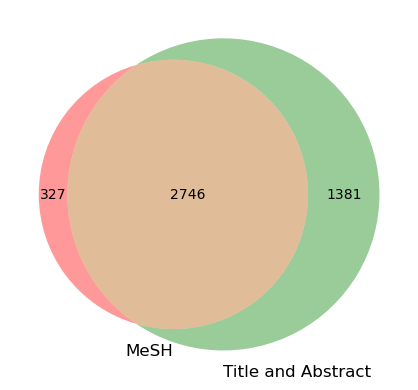

'There are 327 articles where Rett Syndrome is mentionned in the article, but not in the title & abstract!\nNote that MeSH is very good for modern papers, but annotation is quite poor for older ones. A lot of information is still locked up in physical papers,\nnot even available in PubMed.'

In [20]:
# using matplotlib_venn to plot a venn diagram of the results

# create the venn diagram
venn2([set(q1_ids), set(q2_ids)], ('MeSH', 'Title and Abstract'))

# show the plot
plt.show();

'''There are 327 articles where Rett Syndrome is mentionned in the article, but not in the title & abstract!
Note that MeSH is very good for modern papers, but annotation is quite poor for older ones. A lot of information is still locked up in physical papers,
not even available in PubMed.'''

In [23]:
# We'll pick the FIRST UNIQUE article from each search and retrieve the title and abstract

# define a function to retrieve the title, abstract and authors for a given PMID
def pubmed_fetch_tiab(pmid, api_key, email):
        
        # define the parameters for the eFetch request
        efetch_params = {
            'db': 'pubmed',
            'id': pmid,
            'retmode': 'xml',
            'api_key': api_key,
            'email': email
        }

        # encode the parameters so they can be passed to the API
        encoded_data = urllib.parse.urlencode(efetch_params).encode('utf-8')

        # the base request url for eFetch
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"

        # make the request
        request = urllib.request.Request(url, data=encoded_data)
        response = urllib.request.urlopen(request)

        # read into an XML object
        efetch_data_XML = ET.fromstring(response.read())

        # extract the title, abstract and MeSH terms
        for article in efetch_data_XML.findall('PubmedArticle'):
            title = article.find('MedlineCitation/Article/ArticleTitle').text
            abstract = article.find('MedlineCitation/Article/Abstract/AbstractText').text
            mesh_terms = [mesh.text for mesh in article.findall('MedlineCitation/MeshHeadingList/MeshHeading/DescriptorName')]

        return title, abstract, mesh_terms

In [25]:
# find the list of pmids that are unique to q1_ids
q1_unique_ids = list(set(q1_ids) - set(q2_ids))
q2_unique_ids = list(set(q2_ids) - set(q1_ids))


#define a function that will randomly pick a PMID from a list until one is found that has a title and abstract
def get_tiab_from_list(ids, api_key, email):
    while True:
        pmid = random.sample(ids, 1)[0]
        try:
            title, abstract, mesh_terms = pubmed_fetch_tiab(pmid, api_key, email)
            if title and abstract and mesh_terms:
                return title, abstract, mesh_terms
            else:
                pass
        except:
            pass

# fetch the title and abstract for the random examples
q1_title, q1_abstract, q1_mesh_terms = get_tiab_from_list(q1_unique_ids, api_key, email)
q2_title, q2_abstract, q2_mesh_terms = get_tiab_from_list(q2_unique_ids, api_key, email)

# print the results for q1
# print the title ALLCAPS
print(q1_title.upper())
# wrap the abstract at 80 characters
print('\n'.join([q1_abstract[i:i+80] for i in range(0, len(q1_abstract), 80)]), '\n')
# print the mesh terms as a tab intended list one term per line
print('MeSH Terms:')
print('\n'.join(q1_mesh_terms))

# print the results for q2
# print the title ALLCAPS
print(q2_title.upper())
# wrap the abstract at 80 characters
print('\n'.join([q2_abstract[i:i+80] for i in range(0, len(q2_abstract), 80)]))
# print the mesh terms as a tab intended list one term per line
print('MeSH Terms:')
print('\n'.join(q2_mesh_terms))

EXPANDING GENOTYPE-PHENOTYPE CORRELATIONS IN FOXG1 SYNDROME: RESULTS FROM A PATIENT REGISTRY.
We refine the clinical spectrum of FOXG1 syndrome and expand genotype-phenotype 
correlations through evaluation of 122 individuals enrolled in an international 
patient registry. 

MeSH Terms:
Humans
Rett Syndrome
Genotype
Seizures
Frameshift Mutation
Registries
Nerve Tissue Proteins
Forkhead Transcription Factors
CLINICAL MANIFESTATION OF CDKL5 DEFICIENCY DISORDER AND IDENTIFIED MUTATIONS IN A COHORT OF SLOVAK PATIENTS.
CDKL5 deficiency disorder (CDD) is an independent clinical entity associated wit
h early-onset encephalopathy, which is often considered the type of epileptic en
cephalopathy with CDKL5 mutation also found in children diagnosed with early-ons
et seizure (Hanefeld) type of Rett syndrome, epileptic spasms, West syndrome, Le
nnox-Gastaut syndrome, or autism. Since early seizure onset is a prominent featu
re, in this study, a cohort of 54 unrelated patients consisting of 26 males

In [ ]:
'''Now we want to try to learn something about Rett Syndrome from these papers.
One obvious thing to do is to see look at the distrubution of MeSH terms associated with the papers'''

In [26]:
#define a function to retrieve ALL the MeSH terms for a list of PMIDs (i.e. ALL the papers)
def pubmed_fetch_mesh_terms(pmids, api_key, email):
    
    # define the parameters for the eFetch request
    efetch_params = {
        'db': 'pubmed',
        'id': ','.join(pmids),
        'retmode': 'xml',
        'api_key': api_key,
        'email': email
    }

    # encode the parameters so they can be passed to the API
    encoded_data = urllib.parse.urlencode(efetch_params).encode('utf-8')

    # the base request url for eFetch
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"

    # make the request
    request = urllib.request.Request(url, data=encoded_data)
    response = urllib.request.urlopen(request)

    # read into an XML object
    efetch_data_XML = ET.fromstring(response.read())

    # extract the MeSH terms
    mesh_terms = []
    for article in efetch_data_XML.findall('PubmedArticle'):
        try:
            mesh_terms.extend([mesh.text for mesh in article.findall('MedlineCitation/MeshHeadingList/MeshHeading/DescriptorName')])
        except:
            pass

    # create a dictionary of the MeSH terms and their counts (count MeSH frequency)
    mesh_terms_dict = {}
    for term in mesh_terms:
        if term in mesh_terms_dict:
            mesh_terms_dict[term] += 1
        else:
            mesh_terms_dict[term] = 1
    
    return mesh_terms_dict

'What can we immediately learn from this data?'

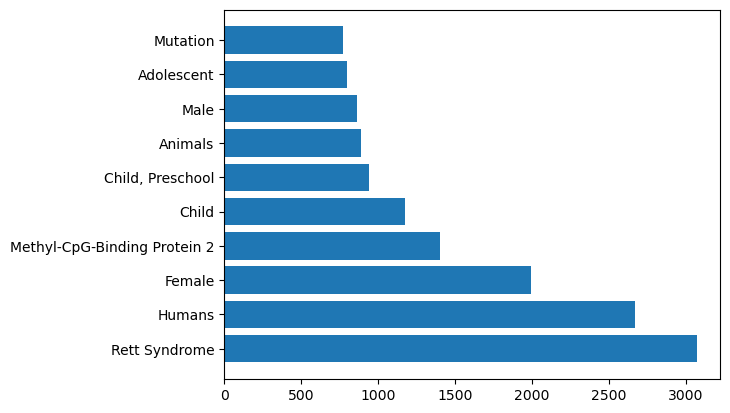

In [27]:
#extract the MeSH term data for all the "Rett Syndrome[MH]" papers
pmids = q1_ids # this we derived right at the top of the notebook

mesh_dict = pubmed_fetch_mesh_terms(pmids, api_key, email)

# sort the dictionary by the counts
sorted_mesh_dict = dict(sorted(mesh_dict.items(), key=lambda item: item[1], reverse=True))

# plot the top 10 MeSH terms
plt.barh(list(sorted_mesh_dict.keys())[:10], list(sorted_mesh_dict.values())[:10]);

'''What can we immediately learn from this data?'''

In [28]:
'''lets use eLink to find any OMIM records that refer to these papers.
Remember OMIM - Online Mendelian Inheritance in Man - is a curated database of human genes and genetic disorders
If using link name, don't need "database from" and "database to" commands, returns exactly what you need.'''

def get_pubmed_omim(pmids):

    # NB you can see all the links (an astonishing number)
    # https://eutils.ncbi.nlm.nih.gov/entrez/query/static/entrezlinks.html#pubmed
    # we are going to use the pubmed_omim_calculated link as this finds OMIM records that cite our papers

    # convert the list of pmids to a string where each pmid is preceded by 'id=' and separated by an &
    pmid_string = '&id='.join(pmids)
    
    # Define the parameters for the eSearch request
    # Notice how we don't have to specify the dbfrom and db elements if we use the linkname
    elink_params = {
        'linkname': 'pubmed_omim_calculated',
        'api_key': api_key,
        'email': email,
    }
    # encode the parameters so they can be passed to the API
    encoded_data = urllib.parse.urlencode(elink_params).encode('utf-8')
    encoded_data = encoded_data + pmid_string.encode('utf-8')

    # the base request url for eSearch
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi"

    # make the request
    request = urllib.request.Request(url, data=encoded_data)
    response = urllib.request.urlopen(request)
    
    # read into an XML object
    elink_data_XML = ET.fromstring(response.read())

    # list to store the pubmed_ids of the cited papers
    omim_records = []

    # extract the gene ids from the links
    for link in elink_data_XML.findall('LinkSet/LinkSetDb/Link/Id'):
        omim_records.append(link.text)

    return omim_records
'''Pull the papers, and then do an analysis.'''


In [ ]:
'''Note that all the equeries have the same structure!'''

In [29]:
# create a list of OMIM entries linked to the papers
omim_records = get_pubmed_omim(pmids)

# find the unique gene ids from the list
unique_omim_records = list(set(omim_records))

# print the number of unique records
print(f'There are',len(unique_omim_records),'unique OMIM records linked to the papers')

There are 285 unique OMIM records linked to the papers


In [162]:
# use eSummary to retrieve the titles of the OMIM records
def get_omim_titles(omim_records):

    # convert the list of omim records to a string where each omim record is followed by a [MIM] in an 'OR' separated string
    omim_string = ' OR '.join([record + '[MIM ID]' for record in omim_records])
    
    # Define the parameters for the eSearch request
    esearch_params = {
        'db': 'omim',
        'term': omim_string,
        'api_key': api_key,
        'email': email,
        'usehistory': 'y'
    }

    # encode the parameters so they can be passed to the API
    encoded_data = urllib.parse.urlencode(esearch_params).encode('utf-8')

    # the base request url for eSearch
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"

    # make the request
    request = urllib.request.Request(url, data=encoded_data)
    response = urllib.request.urlopen(request)

    # read into an XML object
    esearch_data_XML = ET.fromstring(response.read())

    # extract the WebEnv and QueryKey
    webenv = esearch_data_XML.find('WebEnv').text
    query_key = esearch_data_XML.find('QueryKey').text

    # define the parameters for the eSummary request
    esummary_params = {
        'db': 'pubmed',
        'query_key': query_key,
        'WebEnv': webenv,
        'api_key': api_key,
        'email': email
    }

    # encode the parameters so they can be passed to the API
    encoded_data = urllib.parse.urlencode(esummary_params).encode('utf-8')

    # the base request url for eSearch
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"

    # make the request
    request = urllib.request.Request(url, data=encoded_data)
    response = urllib.request.urlopen(request)

    # read into an XML object
    esummary_data_XML = ET.fromstring(response.read())

    # extract the titles of the OMIM records
    omim_titles = {}

    for record in esummary_data_XML.findall('DocSum'):
        try:
            omim_id = record.find('Id').text
            omim_title = record.find('Item[@Name="Title"]').text
            omim_titles[omim_id] = omim_title
        except:
            pass

    return omim_titles

In [ ]:
# get the titles of the OMIM records
omim_titles = get_omim_titles(unique_omim_records)

# convert this into a dataframe where the index is the OMIM ID and the column is the title
'''### YOUR CODE HERE ###'''

In [ ]:
# count the number of times each OMIM record is cited from the omim_records list
omim_records_dict = {}

for record in omim_records:
    '''### YOUR CODE HERE ###'''

# sort the dictionary by the counts
sorted_omim_records_dict = '''### YOUR CODE HERE ###'''

#convert the dictionary to a dataframe
df_omim = pd.DataFrame.from_dict(sorted_omim_records_dict, orient='index', columns=['Count'])

# merge the dataframe with the omim_names dataframe
combined = '''### YOUR CODE HERE ###'''

#remove the index column
combined.reset_index(inplace=True)

#rename the columns
combined.columns = ['OMIM ID', 'Count', 'Title']

# print the dataframe
combined.head()

In [ ]:
# plot the top 10 OMIM records
'''### YOUR CODE HERE ###'''

In [ ]:
'''Well Done!'''